# QF608 Research Methods for Quantitative Professionals Group Project
**Topic 6: Deep Reinforcement Learning for Financial Markets Trading**

**Submitted by: Group 7 (JARVIS)**

**Members: Ankit Rawat, Bryant Ng Zhe Ling, Gan Yingzi, Li Chenpeng, Nguyen Quang Hieu, Wen Yaohao, Zhang Chuanyu**

## Abstract

Trading for financial markets is usually performed using multiple strategies, using various forms of fundamental and technical research. Technical analysis of financial markets usually involves chart pattern analysis by market traders and analysts. Fundamental analysis involves the analysis of a particular company’s past and current financial statements and earnings reports. With the advancements in technology in the field of artificial intelligence (AI) over the past decade, there have been attempts to carry over such innovations to the field of financial markets trading and combine the two. Quantitative analysis no longer involves the use of purely mathematical and statistical concepts and has evolved to include various machine learning and deep learning techniques. In this paper, we are proposing a deep reinforcement learning (DRL) architecture that combines the use of multiple algorithms within an ensemble DRL strategy to adapt and autonomously make trading decisions in the dynamic financial markets and evaluating its backtesting performance.

## Literature Review

Training an intelligent agent for automated financial assets trading has been a subject of much interest ever since the field of artificial intelligence was broached, and recent breakthroughs in the field have only served to move the concept of such an agent closer to the realm of possibility than myth. The process of trading can be modelled as a dual decision-making problem involving the critical tasks of market condition summarization and optimal action execution [cite](). However, in the absence of supervised information from human input, dynamic decision making posits an additional degree of challenge as compared to standard learning tasks. The market modelling problem posed to the agent-in-training remains to both explore an unknown environment by itself and make correct trading decisions simultaneously.

A collection of different approaches has been attempted previously, and they can be categorized broadly along into three separate arms: traditional financial analysis, machine learning (ML) approaches, and deep learning (DL) approaches.

In approaches utilizing traditional financial analysis, mathematics is adopted to recognize historical time series patterns and make predictions. Common models include autoregressive moving average (ARMA) models and generalized autoregressive conditional heteroskedasticity (GARCH) models. ARMA models, by definition, contain both autoregressive (AR) and moving average (MA). The AR-integrated MA (ARIMA) model, a generalization of an ARMA model, is a popular method for time series analysis in economics by backfitting to historical data and then forecasting the future. GARCH models are commonly applied in the field of asset pricing, risk management, and volatility forecasting.

With the development of ML/DL approaches, neural networks have been shown to have predictive ability over both single dimensional and multi-dimensional data extracted from financial time series. Recurrent neural networks (RNN) have been designed and shown to excel at extracting temporal information from raw sequential data. Popular RNN variations, such as long short-term memory (LSTM) networks, have been proposed to mitigate the gradient vanishing problem and achieve state-of-the-art results in a variety of sequential data prediction problems [cite](). A caveat to this, though, is that RNN does not perform as well when applied to financial data as compared to speech and text analysis [cite](). Convolutional neural networks (CNN), being able to take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and differentiate one from the other, have been shown to be suited for predicting the price movements of stocks by utilizing images embedded as multi-dimensional numeric matrices and recognizing patterns within the analysis of time series data.

However, many of the existing ML/DL approaches to financial market trading try to predict price movements or trends, rather than training a trading agent to evaluate trading decisions and execute said decisions independently in a dynamic market. With the history prices of all assets as its input, a neural network can produce an output of predicted vector of asset prices for the next period, which is then be acted upon by the agent. This idea is easy enough to implement because it is a form of supervised learning, or more specifically a regression problem. While the performance of these price-prediction-based algorithms have demonstrated sufficient accuracy in the market modelling and tendency classification, they are not robust to the dynamic real market and cannot be directly applied to algorithmic trading due to their dependence on the degree of prediction accuracy. Another approach is to predict actions (i.e., buy, sell, or hold) using classification algorithms. The problem with this approach is that we must label the data, but the labelling methods often either are very subjective [cite]() or do not generalize well [cite](). As it turns out, future market prices are difficult to predict, with financial time series containing a large amount of noise, including but not limited to the manipulation of large investors, the impact of news and notices, and the uncertain trading behaviors of investors. These noises lead to the highly non-stationary nature of financial time series, which decrease the generalization capability of the model. Additionally, since price predictions are not market actions, there exists an additional layer of logic needed for the conversion of mapping the market prediction to the trading action in strategies, such as the buy, sell, and hold actions stated above. If this layer is a hand-coded, human input, then the entire approach is not a pure machine learning approach, and thus is not very extensible or adaptable [cite]().

This leaves us with a gap, or motivation to find an alternative approach towards coming up with a profitable, fully automated trading strategy.

Against this background, a DRL strategy stands out. By its nature of continuous self-learning, a DRL approach does not need large, labeled training datasets, which may prove to be of significant advantage with time since the amount of data is growing exponentially, making it increasingly time and labor intensive to label a large dataset. It also uses a reward function to optimize future rewards, with the ability to improve policy over time via self-learning helping to convert problems into an
optimization problem rather than a standard regression/classification model that predicts the probability of future outcomes like previous ML/DL approaches.

In our paper, we are looking to adopt an ensemble strategy based on DRL that combines multiple types of DRL algorithms to find the optimal trading strategy in a complex and dynamic stock market. The three algorithms are Proximal Policy Optimization (PPO), Advantage Actor Critic (A2C), and Deep Deterministic Policy Gradient (DDPG). It combines the best features of the three algorithms, allowing the strategy to adjust to different market conditions, making it more robust and reliable and maximizing return subject to risk constraint.

## Research Design

Due to the copious amounts of training time needed, we are only training an example of stoploss_2way on 700,000 training samples over 4.2M total timesteps. The maximum trading balance has been designed so that the agent can use 100% of the current balance for a single trade. Also, the learning rate of the agent has been fine-tuned and set at 0.0003, linearly scheduled.

### Import Packages

In [6]:
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%config IPCompleter.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# general
import datetime
from tqdm import tqdm
import operator
from pprint import pprint
import sys
import os
import itertools

# data processing
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# stable baselines
import gym
import torch
from stable_baselines.common import set_global_seeds, make_vec_env
from stable_baselines.common.policies import MlpLnLstmPolicy
from stable_baselines.common.noise import OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec
from stable_baselines.ddpg import LnMlpPolicy
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.policies import ActorCriticPolicy 
from stable_baselines3.ppo import PPO

# finrl
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models_ext import DRLAgent, DRLEnsembleAgent
from finrl.trade.backtest import (
    backtest_stats, backtest_plot, get_daily_return, get_baseline,
    convert_daily_return_to_pyfolio_ts
)
from finrl.model.policy import CustomActorCriticPolicy
from finrl.util import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data Processing

Our initial 1-minute FX raw data has a small portion of missing values. We will handle this by linearly interpolating the OHLC with respect to timestamp.

Also, we will be adding technical indicators as features of our input. Hence, the input (or state) of DRL contains features about the current balance, current close price, current number of position in the asset, and technical indicators of the asset. This input can also be extended to two-dimensional data , in which case we stack one-dimensional feature input for a specified window of timestamps. To run the `sortino` reward function, risk-free rates will also be added. The processed data is shown below.

In [8]:
processed_full = pd.read_csv('data/processed.csv')
processed_full.date = pd.to_datetime(processed_full.date)

In [9]:
# Adding risk-free rates
ff = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=2)
ff = ff.rename({'Unnamed: 0': 'Date'}, axis=1)
processed_full['day'] = processed_full.date.dt.strftime('%Y%m%d').astype(np.int64)
df = pd.merge(processed_full, ff[['Date', 'RF']], left_on=['day'], right_on=['Date'], how='left')
df = df.ffill().bfill()
df = df.drop(['day', 'Date'], axis=1)
processed_full = df.copy()
processed_full.drop('turbulence', axis=1, inplace=True)

In [10]:
processed_full.head()

,date,open,high,low,close,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,RF
0,2008-01-01 19:00:00,1.4621,1.4621,1.46210,1.4621,eurusd,0.000000,1.462100,1.462100,0.0,66.666667,100.000000,1.462100,1.462100,0.01
1,2008-01-01 19:01:00,1.4622,1.4622,1.46210,1.4621,eurusd,0.000000,1.462100,1.462100,0.0,66.666667,100.000000,1.462100,1.462100,0.01
2,2008-01-01 19:02:00,1.4621,1.4621,1.46195,1.4620,eurusd,-0.000003,1.462182,1.461951,0.0,-100.000000,23.178808,1.462067,1.462067,0.01
3,2008-01-01 19:03:00,1.4620,1.4620,1.46180,1.4619,eurusd,-0.000008,1.462216,1.461834,0.0,-115.789474,53.676673,1.462025,1.462025,0.01
4,2008-01-01 19:04:00,1.4618,1.4619,1.46180,1.4618,eurusd,-0.000015,1.462241,1.461719,0.0,-104.700855,53.676673,1.461980,1.461980,0.01


### Environment

The trading environment has 3 main components: `state space (or observation space), action space, and reward function`.

As described above, the input can be of any number of dimensions. Our current trading environment only allows for `1D` or `2D` data at the moment. The action space is continuous, taking values from and including `-1` to `1`. The value of the action will then be multiplied with `hmax`, which determines the maximum amount of a single trade. For example, if the action is `0.5` and `hmax` is equal to the initial balance, `10000`, then the agent will buy `5000` worth of assets. Correspondingly, a negative action value mean cause the agent to sell assets.

The `reward function` is one of our core targets for this project. We will implement and test 3 types of reward functions: `pnl`, `stoploss`, and `sortino`. For `stoploss` reward function, we have separate, different implementations to observe the effects of type of stop-loss strategy on overall performance.

To be compatible with OpenAI gym, we also need to specify `step(action)` function, which takes as input an action and produces a result when the agent executes the action. The result usually contains, among other things, the next state, the reward for taking the action, and the terminal status (whether the game ends or not). 

The environment also accepts parameters such as `commission fees`, and other factors relevant to each reward function. 

In [11]:
stock_dimension = len(processed_full.tic.unique())
# state_space = balance + num_stocks*(close, proportion, TAs)
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [12]:
env_kwargs = {
    "hmax": 10000, 
    "hmin": 1,
    "initial_amount": 10000, 
    "buy_cost_pct": 0.0, 
    "sell_cost_pct": 0.0,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "print_verbosity":1,
    "reward_method": 'stoploss_2way'
}

### Training and Validating Data
We divide the total processed data into 2 sets, training data and validation data, which accounts for `70% and 30%` of the data respectively. The time range is shown below:

In [13]:
# Split train-val-test
train_len = int(len(processed_full) * 0.7)
test_len = int(len(processed_full) * 0.3)

train_start = processed_full.date[0]
train_end = processed_full.date[train_len]
test_start = processed_full.date[train_len]
test_end = processed_full.date[len(processed_full)-1] + pd.Timedelta('60s') # to include all dates

print(f'Train from {train_start} to {train_end}: {pd.Timedelta(train_end-train_start).days} days')
print(f'Test from {test_start} to {test_end}: {pd.Timedelta(test_end-test_start).days} days')

df_train = data_split(processed_full, train_start, train_end)
df_test = data_split(processed_full, test_start, test_end)

env_train = StockTradingEnv(df_train, **env_kwargs)
env_test = StockTradingEnv(df_test, **env_kwargs)

Train from 2008-01-01 19:00:00 to 2009-05-03 00:40:00: 487 days
Test from 2009-05-03 00:40:00 to 2009-11-27 08:40:00: 208 days


#### Training

Generally, training DRL models are processes that require large amount of time and computational power. For example, the models behind AlphaGo or OpenAI's DOTA2 took years worth of self-play or training time. A simple game like Atari also took 1000 episodes of training to be viable. Given the dual limits of time and computational power, we will only be training our proposed model for 6 episodes, which is specified by the `total_timesteps` parameter as shown below. 

Using multiprocessing, however, we can alleviate that problem to some extent. With one step, the model can experience across different environments, thereby gathering more information. The number of workers is specified by the `num_cpu` parameter below. This does not necessarily mean we train the model for `18 * 6 = 108` episodes because the model does not finish the game in each worker's environment. It just walks more paths, which are generated randomly, hence allowing for faster convergence, and lowering the variance. [Peter Henderson et. al. 2017](https://arxiv.org/pdf/1709.06560.pdf)

In [13]:
%%time
PPO_PARAMS = {
    "n_steps":2048, 
    "batch_size":64, 
    "n_epochs":10,
    "learning_rate":linear_schedule(0.0003)
}

trained_multi_ppo = train_multi_env('ppo', df_train, env_kwargs, PPO_PARAMS, 
                                    policy=MlpPolicy, policy_kwargs=None, 
                                    num_cpu=18, total_timesteps=4200000)

Setting up vectorized env ...

=================Start training=================
{'n_steps': 2048, 'batch_size': 64, 'n_epochs': 10, 'learning_rate': <function linear_schedule.<locals>.func at 0x0000025A0B5C3AF8>}
Using cpu device
Logging to tensorboard_log/ppo\ppo_24
------------------------------
| time/              |       |
|    fps             | 196   |
|    iterations      | 1     |
|    time_elapsed    | 187   |
|    total_timesteps | 36864 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 2           |
|    time_elapsed         | 386         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.005699874 |
|    clip_fraction        | 0.0514      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | -23.2       |
|    learni

------------------------------------------
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 12           |
|    time_elapsed         | 2381         |
|    total_timesteps      | 442368       |
| train/                  |              |
|    approx_kl            | 0.0016800037 |
|    clip_fraction        | 0.00687      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.3         |
|    explained_variance   | -0.00337     |
|    learning_rate        | 0.000271     |
|    loss                 | 0.00327      |
|    n_updates            | 110          |
|    policy_gradient_loss | 0.000152     |
|    std                  | 0.891        |
|    value_loss           | 0.0197       |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 13          |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 23          |
|    time_elapsed         | 4566        |
|    total_timesteps      | 847872      |
| train/                  |             |
|    approx_kl            | 0.002090835 |
|    clip_fraction        | 0.0089      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.22       |
|    explained_variance   | -0.000861   |
|    learning_rate        | 0.000242    |
|    loss                 | 0.0137      |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.000155   |
|    std                  | 0.818       |
|    value_loss           | 0.0372      |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 24           |
|    time_elapsed         | 47

-----------------------------------------
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 34          |
|    time_elapsed         | 6753        |
|    total_timesteps      | 1253376     |
| train/                  |             |
|    approx_kl            | 0.002192882 |
|    clip_fraction        | 0.00917     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.15       |
|    explained_variance   | -0.00181    |
|    learning_rate        | 0.000213    |
|    loss                 | 0.0179      |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.000221   |
|    std                  | 0.761       |
|    value_loss           | 0.0485      |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 35          |
|    time_elapsed         | 6952  

------------------------------------------
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 45           |
|    time_elapsed         | 8939         |
|    total_timesteps      | 1658880      |
| train/                  |              |
|    approx_kl            | 0.0010080809 |
|    clip_fraction        | 0.00502      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.05        |
|    explained_variance   | -0.000993    |
|    learning_rate        | 0.000184     |
|    loss                 | 0.0391       |
|    n_updates            | 440          |
|    policy_gradient_loss | -9.59e-06    |
|    std                  | 0.69         |
|    value_loss           | 0.0691       |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 46           |
|    time_e

-----------------------------------------
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 56          |
|    time_elapsed         | 11125       |
|    total_timesteps      | 2064384     |
| train/                  |             |
|    approx_kl            | 0.002384999 |
|    clip_fraction        | 0.0114      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.986      |
|    explained_variance   | -0.000777   |
|    learning_rate        | 0.000155    |
|    loss                 | 0.0454      |
|    n_updates            | 550         |
|    policy_gradient_loss | -0.000362   |
|    std                  | 0.649       |
|    value_loss           | 0.0733      |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 57           |
|    time_elapsed         | 11

----------------------------------------
| time/                   |            |
|    fps                  | 185        |
|    iterations           | 67         |
|    time_elapsed         | 13303      |
|    total_timesteps      | 2469888    |
| train/                  |            |
|    approx_kl            | 0.00160942 |
|    clip_fraction        | 0.00631    |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.905     |
|    explained_variance   | -0.000709  |
|    learning_rate        | 0.000126   |
|    loss                 | 0.027      |
|    n_updates            | 660        |
|    policy_gradient_loss | -0.000131  |
|    std                  | 0.597      |
|    value_loss           | 0.0671     |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 68           |
|    time_elapsed         | 13501        |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 78          |
|    time_elapsed         | 15487       |
|    total_timesteps      | 2875392     |
| train/                  |             |
|    approx_kl            | 0.001582382 |
|    clip_fraction        | 0.0106      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.83       |
|    explained_variance   | -0.000465   |
|    learning_rate        | 9.72e-05    |
|    loss                 | 0.0637      |
|    n_updates            | 770         |
|    policy_gradient_loss | -0.000271   |
|    std                  | 0.554       |
|    value_loss           | 0.103       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 79           |
|    time_elapsed         | 15

------------------------------------------
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 89           |
|    time_elapsed         | 17665        |
|    total_timesteps      | 3280896      |
| train/                  |              |
|    approx_kl            | 0.0016752853 |
|    clip_fraction        | 0.00407      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.819       |
|    explained_variance   | -0.000504    |
|    learning_rate        | 6.83e-05     |
|    loss                 | 0.0277       |
|    n_updates            | 880          |
|    policy_gradient_loss | -0.000101    |
|    std                  | 0.55         |
|    value_loss           | 0.0596       |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 185           |
|    iterations           | 90            |
|    ti

------------------------------------------
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 100          |
|    time_elapsed         | 19843        |
|    total_timesteps      | 3686400      |
| train/                  |              |
|    approx_kl            | 0.0016683734 |
|    clip_fraction        | 0.00461      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.799       |
|    explained_variance   | -1.11e-05    |
|    learning_rate        | 3.93e-05     |
|    loss                 | 0.0403       |
|    n_updates            | 990          |
|    policy_gradient_loss | -0.00018     |
|    std                  | 0.536        |
|    value_loss           | 0.0754       |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 101          |
|    time_e

------------------------------------------
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 111          |
|    time_elapsed         | 22024        |
|    total_timesteps      | 4091904      |
| train/                  |              |
|    approx_kl            | 0.0021565806 |
|    clip_fraction        | 0.00637      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.763       |
|    explained_variance   | 0.000251     |
|    learning_rate        | 1.04e-05     |
|    loss                 | 0.0321       |
|    n_updates            | 1100         |
|    policy_gradient_loss | -0.000449    |
|    std                  | 0.518        |
|    value_loss           | 0.067        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 112          |
|    time_e

#### Validating

In [14]:
trained_multi_ppo = PPO.load("models/ppo_multienv_stoploss_avg_4.2M_hmax10k_lr0.0003.pkl")

In [15]:
account_memory, actions_memory = test_multi_env(trained_multi_ppo, df_test, env_kwargs)

100%|█████████▉| 299999/300000 [6:21:29<00:00, 13.11it/s]    

hit end!


Text(0, 0.5, 'Account Value ($)')

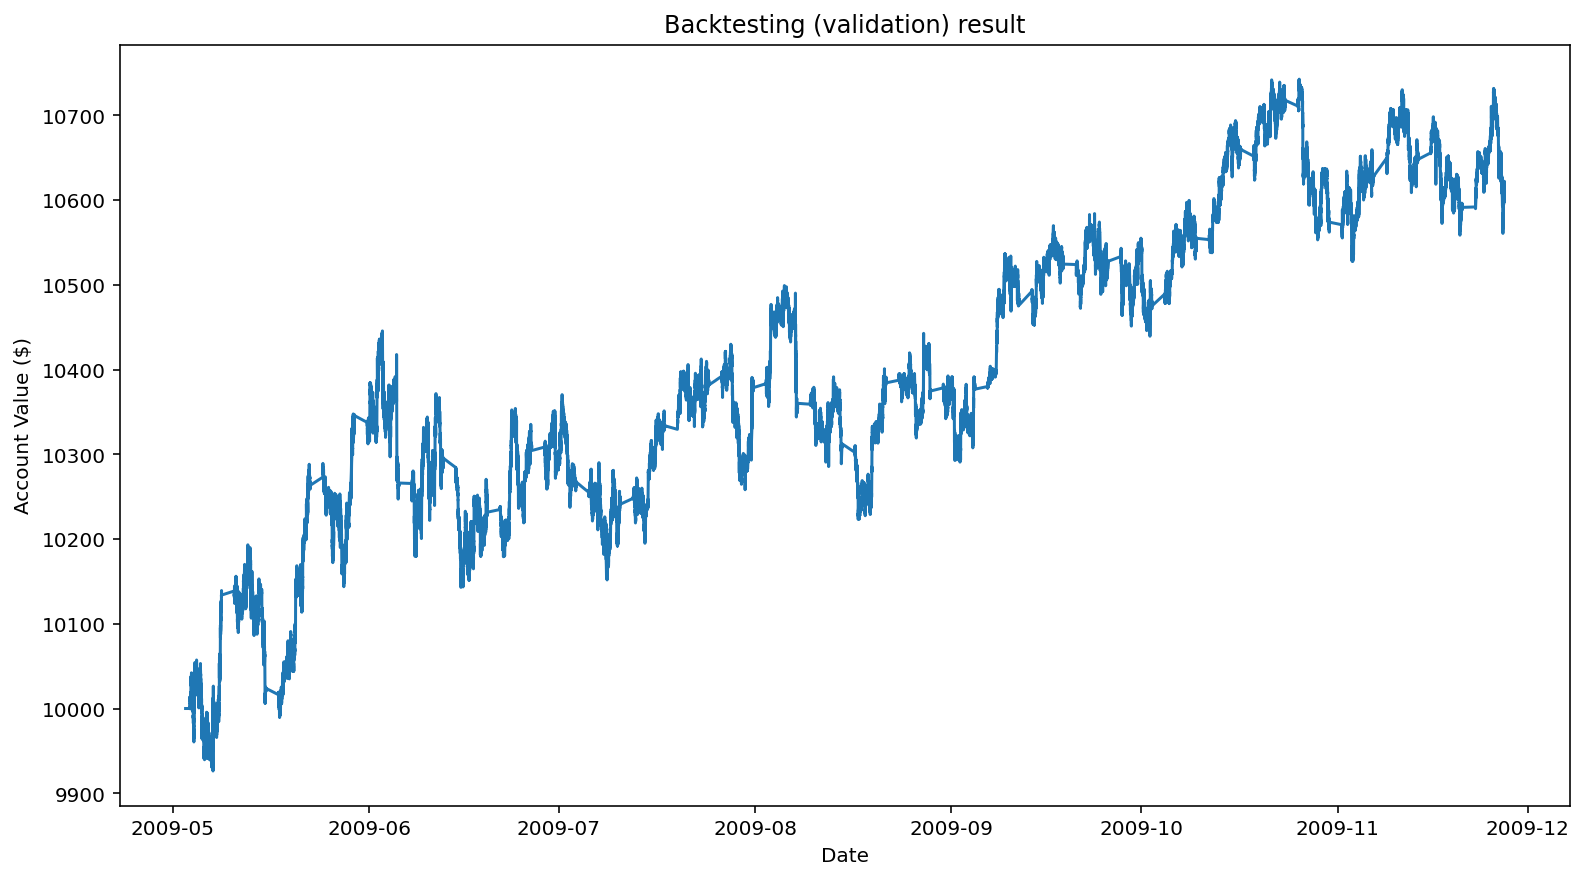

In [16]:
plt.figure(figsize=(13, 7))
plt.plot(df_test.date.unique(), pd.Series(account_memory))
plt.title(f'Backtesting (validation) result')
plt.xlabel('Date')
plt.ylabel('Account Value ($)')

#### Cumulative Return

In [17]:
df_result = pd.DataFrame({
    'date':df_test.date,
    'close':df_test.close,
    'actions':actions_memory,
    'account_memory':account_memory
})

df_result['close_return'] = (df_result.close.pct_change(1)+1).cumprod()
df_result['acc_return'] = (df_result.account_memory.pct_change(1)+1).cumprod()

Text(0, 0.5, 'Return (%)')

<Figure size 864x504 with 0 Axes>

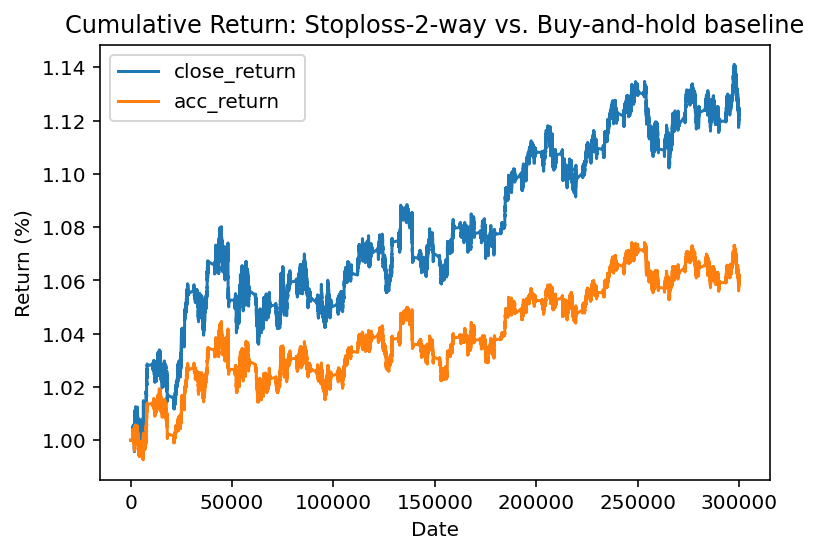

In [18]:
plt.figure(figsize=(12, 7))
df_result[['close_return', 'acc_return']].plot()
plt.title('Cumulative Return: Stoploss-2-way vs. Buy-and-hold baseline')
plt.xlabel('Date')
plt.ylabel('Return (%)')

## Results

In this section, we will compare models trained on different reward functions and architectures. We will also discuss the importance of hyperparameter tuning and training time on the performance of the model.

### Impact of Reward Functions

In [23]:
REWARD_MODELS = [
    'pnl_1M',
    'slavg_1M',
    'pnl_slpct_1M',
    'sortino_1M',
    's2w_1M',
]

In [24]:
all_dict = {}
up_dict = {}
down_dict = {}

for m in REWARD_MODELS:
    up_dict[m] = pd.read_csv(f'data/Reward/account_hist_{m}_up_reward.csv').account_hist
    down_dict[m] = pd.read_csv(f'data/Reward/account_hist_{m}_down_reward.csv').account_hist

up_dates = pd.to_datetime(pd.read_csv(f'data/Reward/account_hist_pnl_1M_up_reward.csv').date)
down_dates = pd.to_datetime(pd.read_csv(f'data/Reward/account_hist_pnl_1M_down_reward.csv').date)

up_closes = pd.read_csv(f'data/Reward/account_hist_pnl_1M_up_reward.csv').close
down_closes = pd.read_csv(f'data/Reward/account_hist_pnl_1M_down_reward.csv').close

up_df = pd.DataFrame(up_dict)
up_df['date'] = up_dates
up_df['close'] = up_closes
down_df = pd.DataFrame(down_dict)
down_df['date'] = down_dates
down_df['close'] = down_closes

#### Up-trending Market

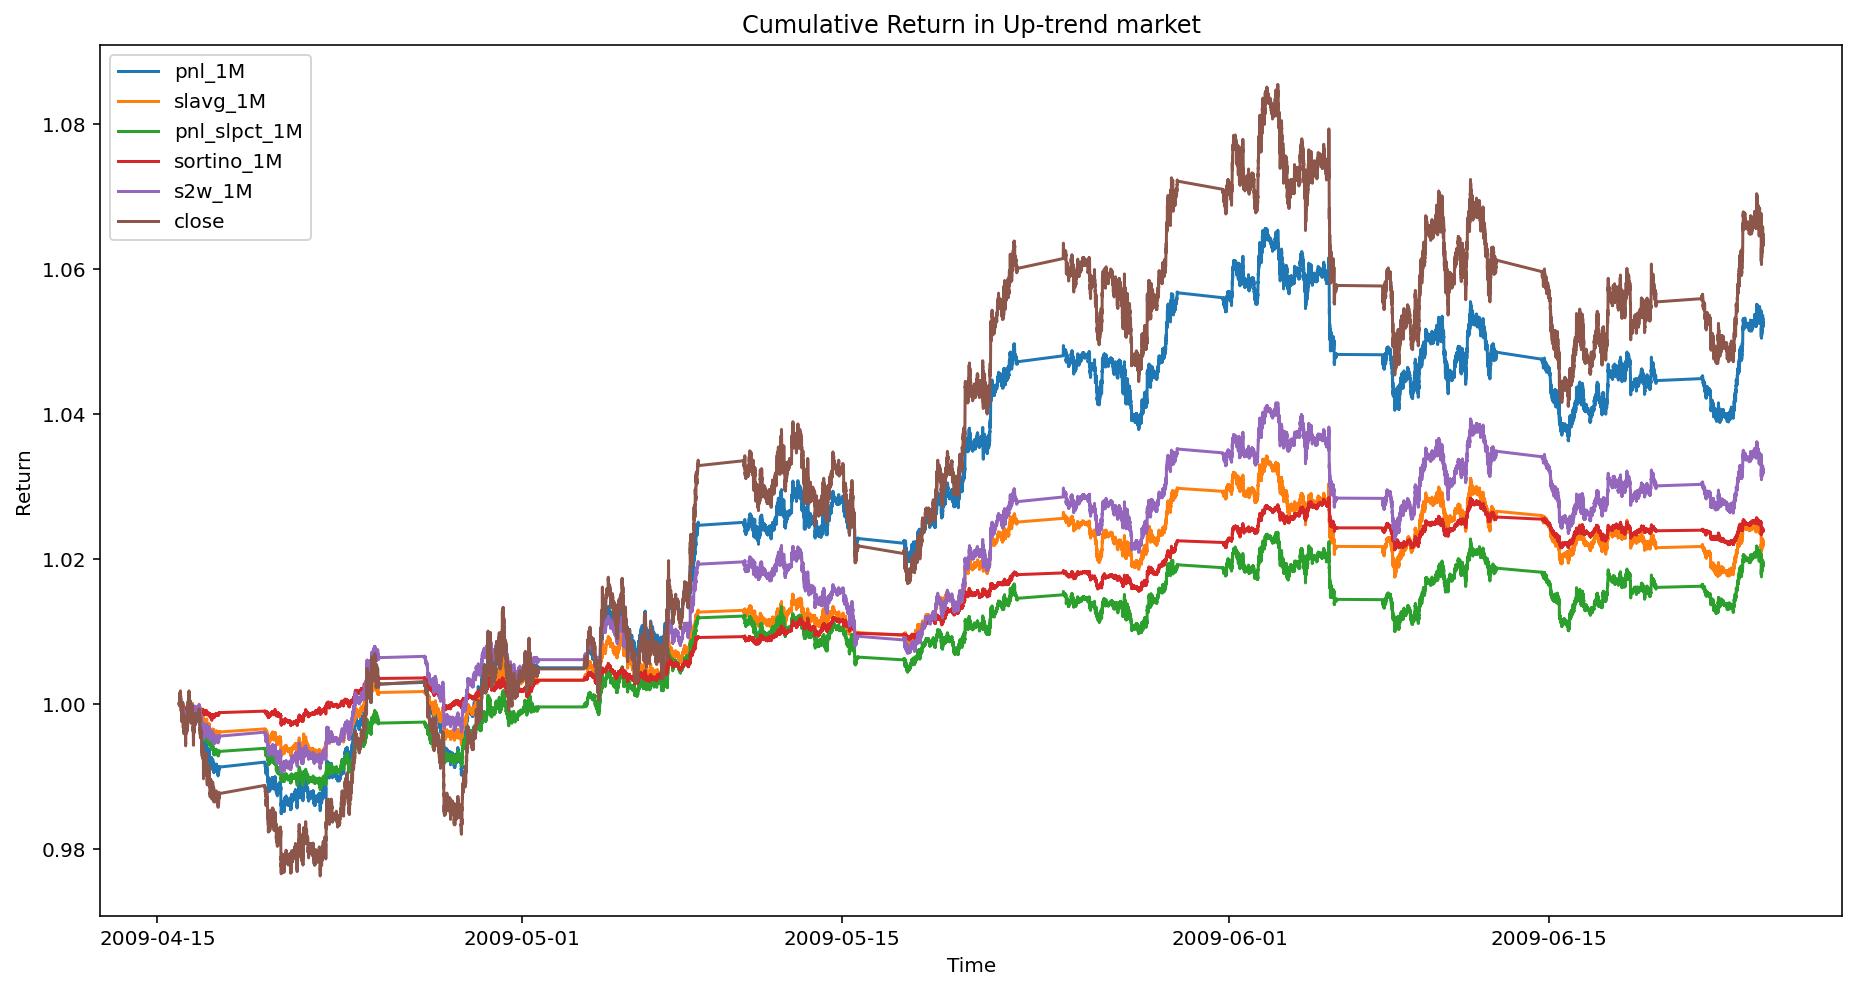

In [25]:
for m in REWARD_MODELS:
     up_df[m+'_return']= (up_df[m].pct_change()+1).cumprod()
up_df['close_return'] = (up_df['close'].pct_change()+1).cumprod()

plt.figure(figsize=(13, 7))
for m in REWARD_MODELS:
    plt.plot(up_df.date, up_df[m+'_return'], label=m)
plt.plot(up_df.date, up_df['close_return'], label='close')

plt.xlabel('Time')
plt.ylabel('Return')
plt.title('Cumulative Return in Up-trend market')
plt.legend()
plt.tight_layout()   
plt.savefig('images/cum_ret_up_reward.png', dpi=300)
plt.show()

#### Down-trending Market

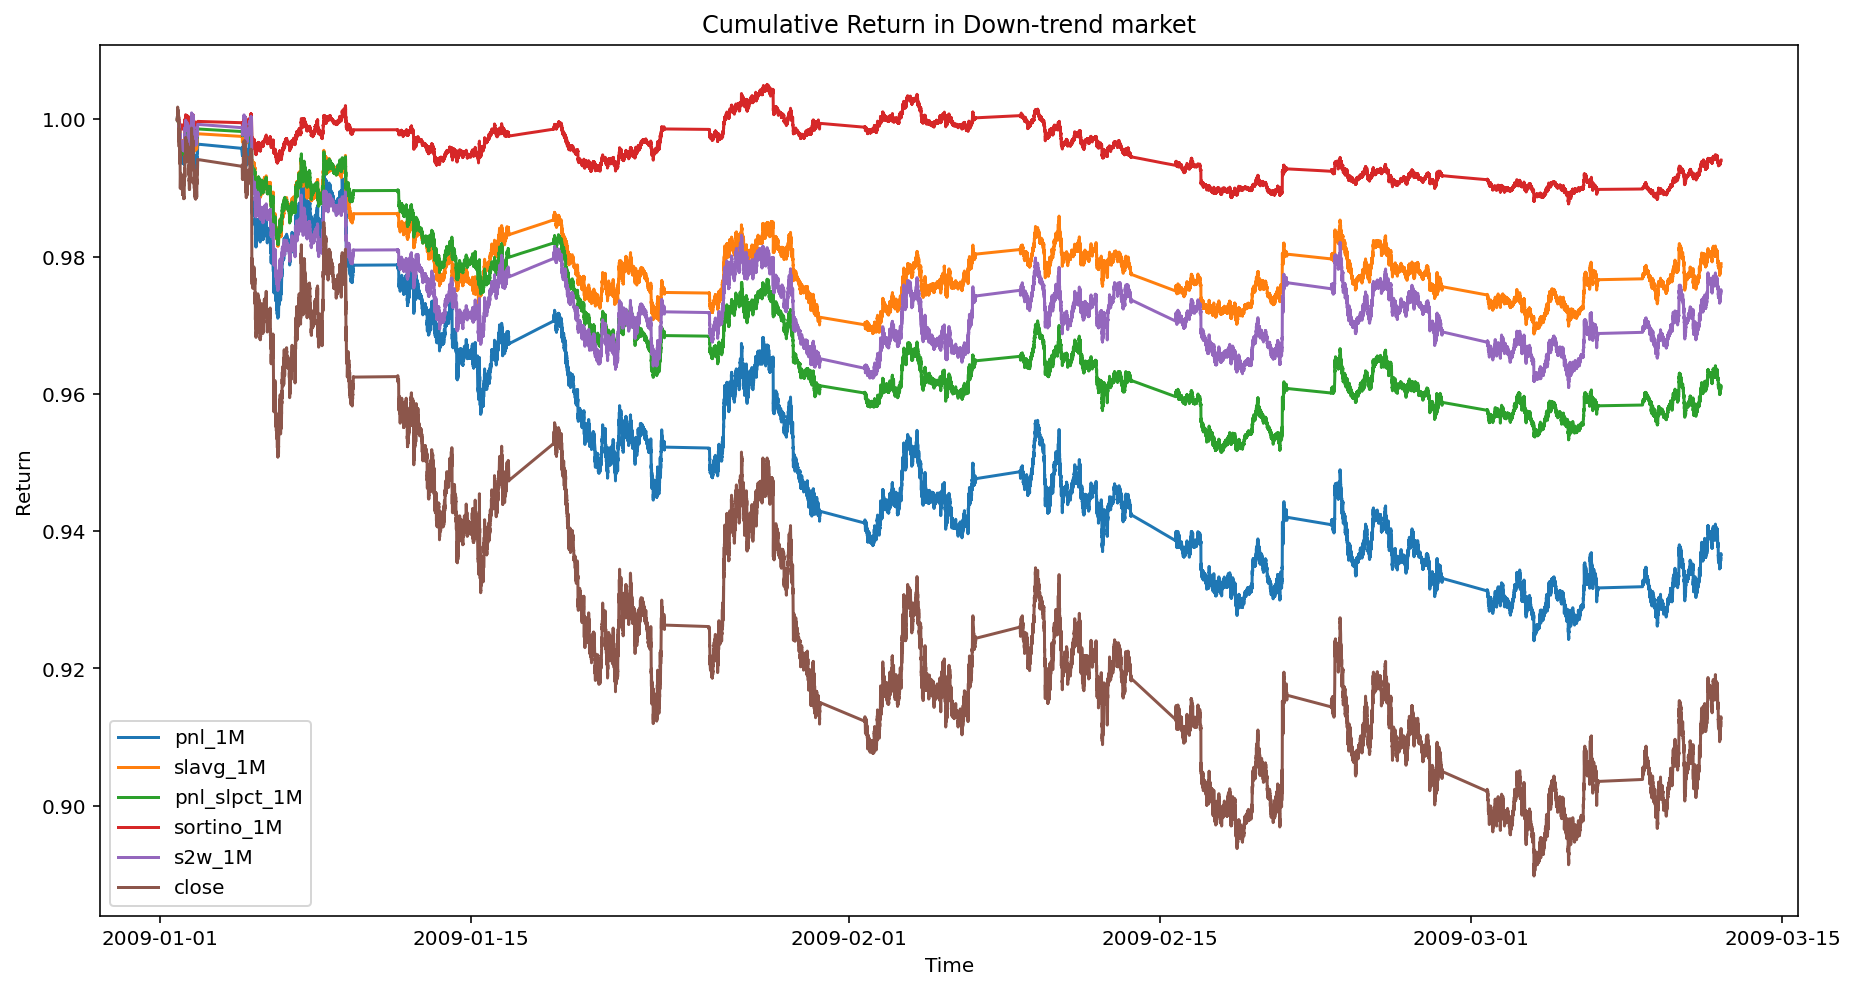

In [26]:
for m in REWARD_MODELS:
     down_df[m+'_return']= (down_df[m].pct_change()+1).cumprod()
down_df['close_return'] = (down_df['close'].pct_change()+1).cumprod()

plt.figure(figsize=(13, 7))
for m in REWARD_MODELS:
    plt.plot(down_df.date, down_df[m+'_return'], label=m)
plt.plot(down_df.date, down_df['close_return'], label='close')

plt.xlabel('Time')
plt.ylabel('Return')
plt.title('Cumulative Return in Down-trend market')
plt.legend()
plt.tight_layout()   
plt.savefig('images/cum_ret_down_reward.png', dpi=300)
plt.show()

### Impact of Training Time (Total Timesteps)

In [27]:
all_dict = {}
up_dict = {}
down_dict = {}

for m in TIME_MODELS:
    up_dict[m] = pd.read_csv(f'data/Time/account_hist_{m}_up_time.csv').account_hist
    down_dict[m] = pd.read_csv(f'data/Time/account_hist_{m}_down_time.csv').account_hist

up_dates = pd.to_datetime(pd.read_csv(f'data/Time/account_hist_s2w_1M_up_time.csv').date)
down_dates = pd.to_datetime(pd.read_csv(f'data/Time/account_hist_s2w_1M_down_time.csv').date)
# all_dates = pd.to_datetime(pd.read_csv(f'data/Time/account_hist_s2w_1M_all_time.csv').date)

up_closes = pd.read_csv(f'data/Time/account_hist_s2w_1M_up_time.csv').close
down_closes = pd.read_csv(f'data/Time/account_hist_s2w_1M_down_time.csv').close
# all_closes = pd.read_csv(f'data/Time/account_hist_s2w_1M_all_time.csv').close

up_df = pd.DataFrame(up_dict)
up_df['date'] = up_dates
up_df['close'] = up_closes
down_df = pd.DataFrame(down_dict)
down_df['date'] = down_dates
down_df['close'] = down_closes
# all_df = pd.DataFrame(all_dict)
# all_df['date'] = all_dates
# all_df['close'] = all_closes

#### Up-trending Market

In [28]:
s2w_1M_returns = (up_df['s2w_1M'].pct_change()+1).cumprod()
s2w_4M_returns = (up_df['s2w_4M'].pct_change()+1).cumprod()
close_returns = (up_df['close'].pct_change()+1).cumprod()

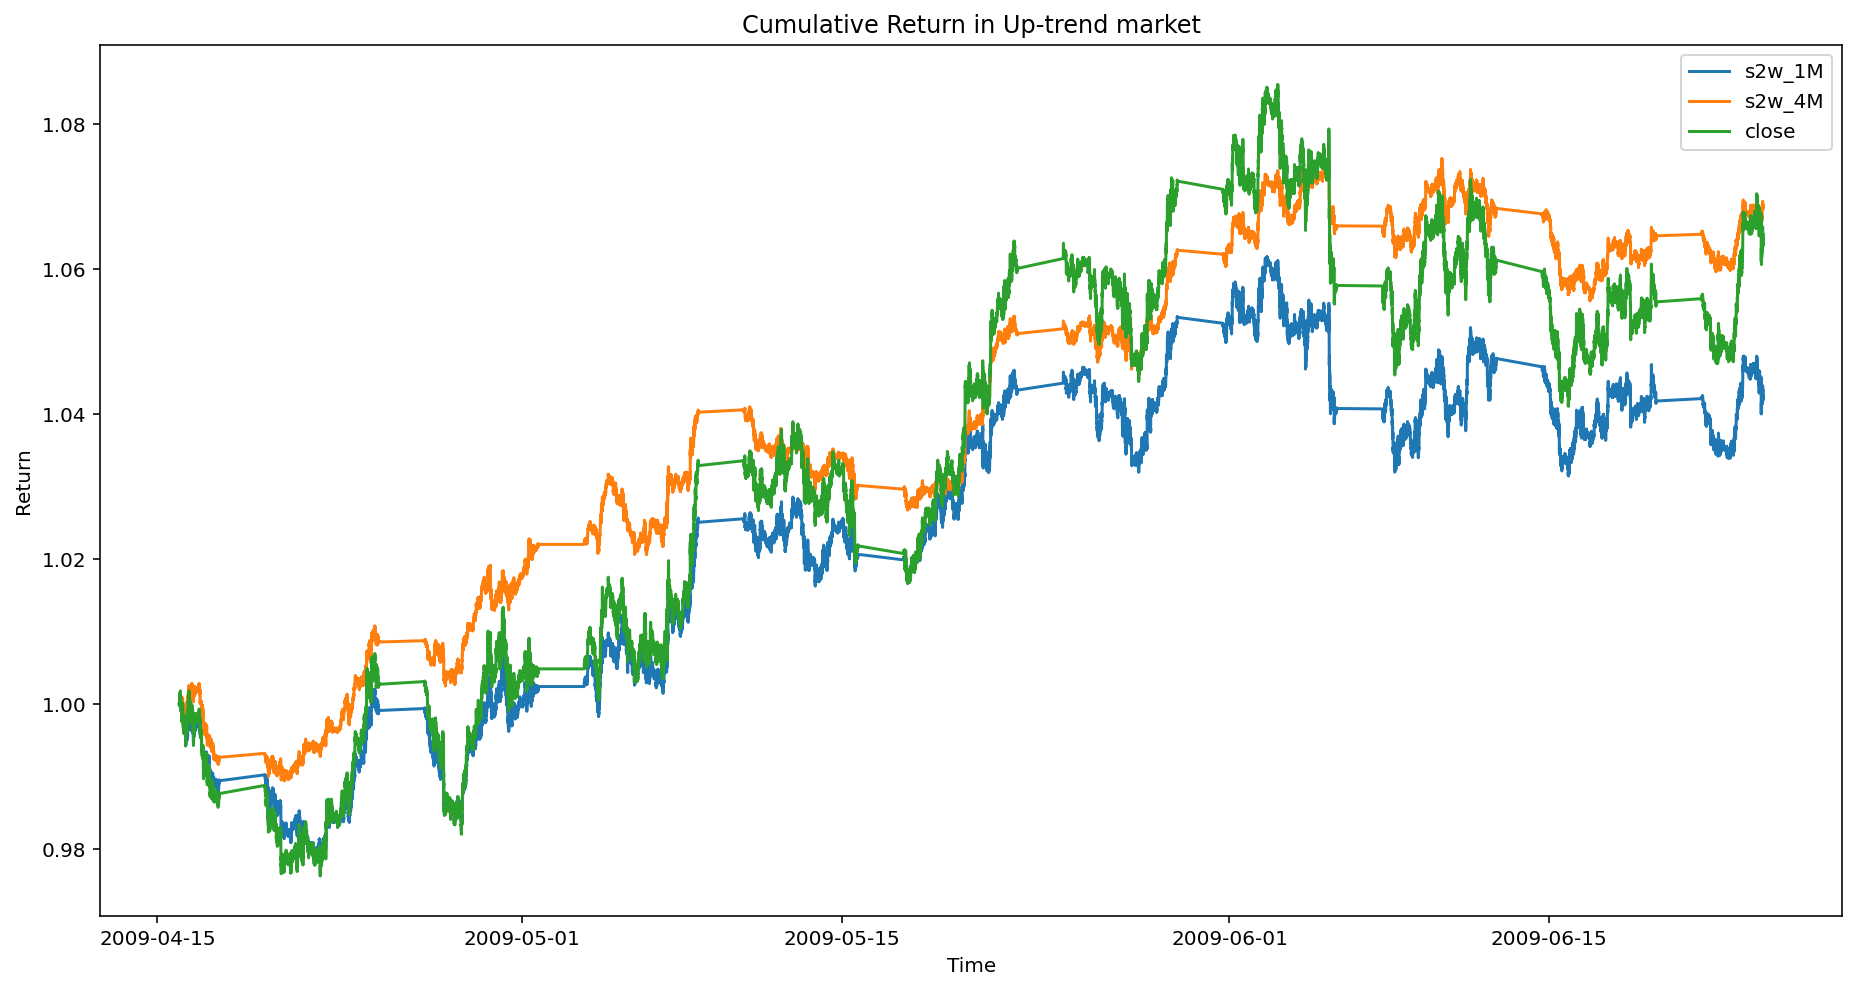

In [29]:
plt.figure(figsize=(13, 7))
plt.plot(up_df.date, s2w_1M_returns, label='s2w_1M')
plt.plot(up_df.date, s2w_4M_returns, label='s2w_4M')
plt.plot(up_df.date, close_returns, label='close')

plt.xlabel('Time')
plt.ylabel('Return')
plt.title('Cumulative Return in Up-trend market')
plt.legend()
plt.tight_layout()   
plt.savefig('images/cum_ret_up_time.png', dpi=300)
plt.show()

#### Down-trending Market

In [30]:
s2w_1M_returns = (down_df['s2w_1M'].pct_change()+1).cumprod()
s2w_4M_returns = (down_df['s2w_4M'].pct_change()+1).cumprod()
close_returns = (down_df['close'].pct_change()+1).cumprod()

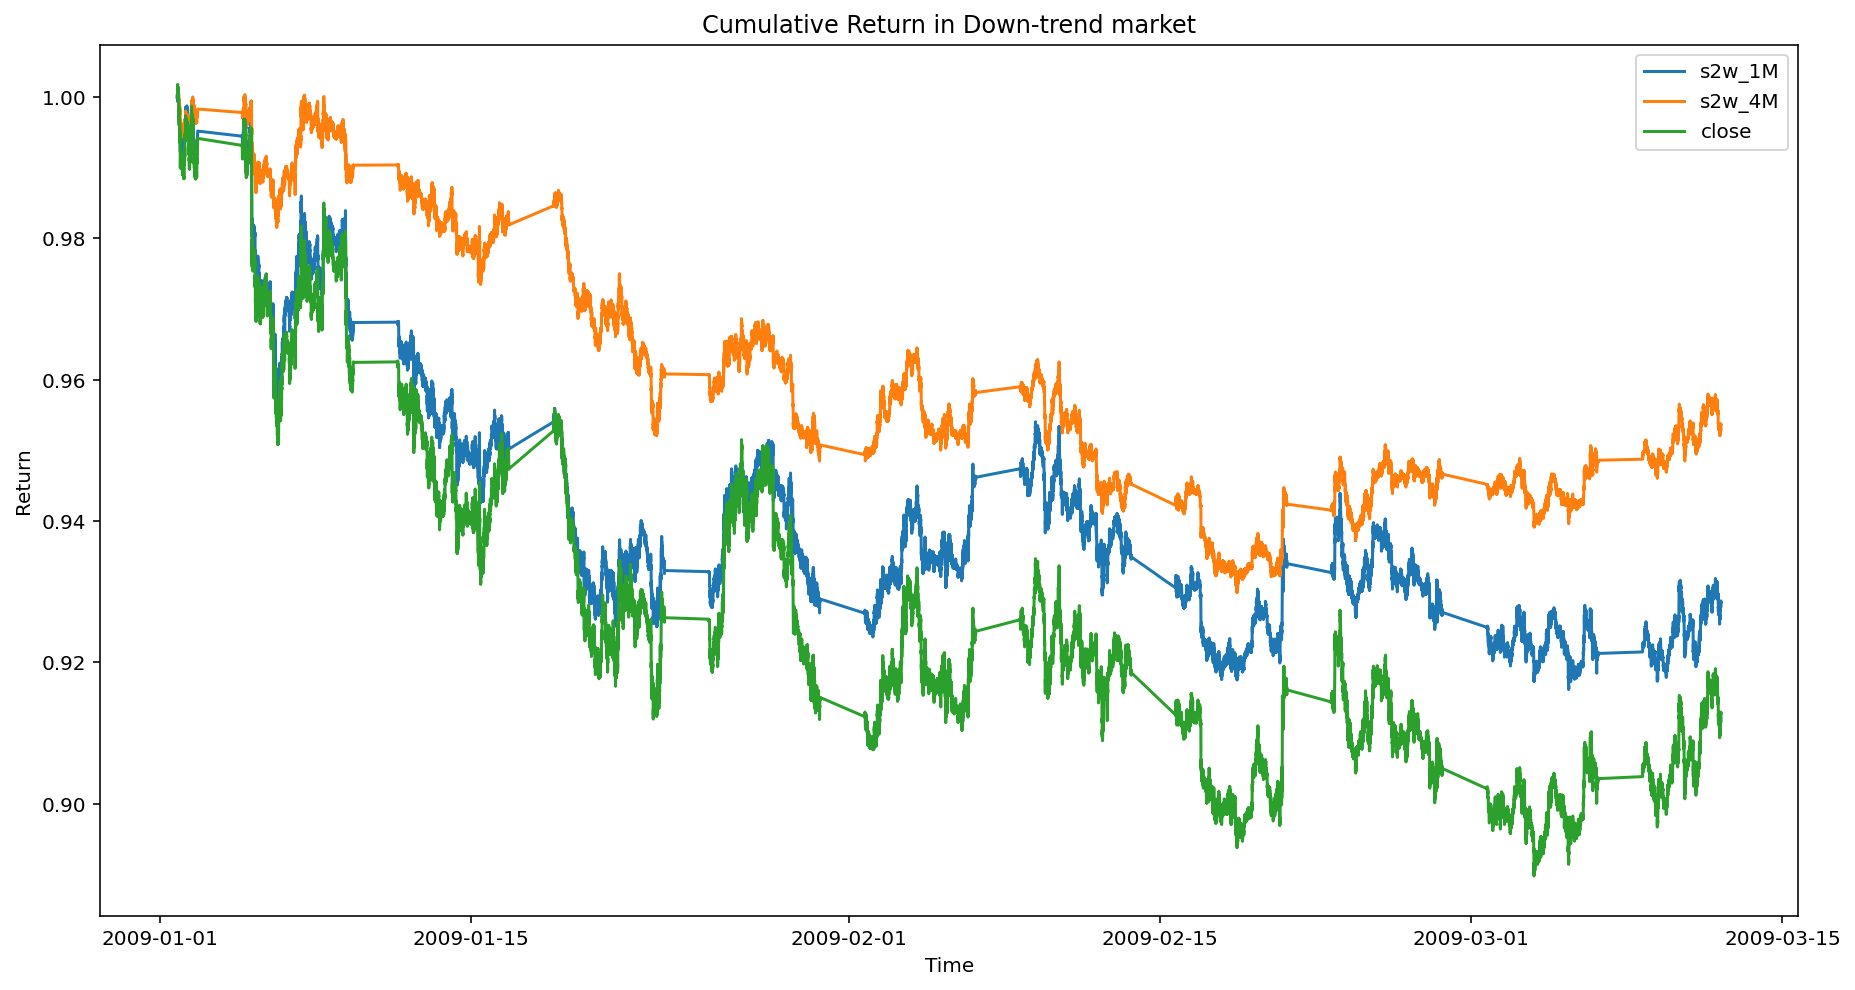

In [31]:
plt.figure(figsize=(13,7))
plt.plot(down_df.date, s2w_1M_returns, label='s2w_1M')
plt.plot(down_df.date, s2w_4M_returns, label='s2w_4M')
plt.plot(down_df.date, close_returns, label='close')

plt.xlabel('Time')
plt.ylabel('Return')
plt.title('Cumulative Return in Down-trend market')
plt.legend()
plt.tight_layout()   
plt.savefig('images/cum_ret_down_time.png', dpi=300)
plt.show()

## Discussion

We can see the clear distinction in performance between different reward functions. One performs very well in up-trending market conditions but tends to lag behind in down-trending market conditions, and vice versa for another reward function. Clearly, reward functions play a pivotol role in solving DRL, or RL problems in general. In spite of our efforts to search for a well-performing reward function in both types of market conditions, current methods present a trade-off in performance between up-trend and down-trend market. Further research can be extended in this direction.

As compared to the buy-and-hold strategy, all of our reward functions, trained for `1 millions timesteps` (equivalent to just over 1 episode), perform worse in an up-trending market, while having better performance in a down-trending market. However, we also attempt to train `stoploss_2way` for `4 millions timesteps` (equivalent to 6 episodes) and it beats both the smaller model and the buy-and-hold baseline. This shows the potential for improvement in the current PPO approach.

Next, comparing the same setting across different architectures, we observe that the `64-by-64 two-layer MLP` is the best configuration for the feature extractor in a one-dimensional environment. Also, it is the most popular configuration in DRL literature ([Amir Mosavi et. al. 2017](https://arxiv.org/pdf/2004.01509.pdf) and [Kai Arulkumaran et. al. 2020](https://arxiv.org/pdf/1708.05866.pdf)). The DRL can easily overfit the training data [Chiyuan Zhang 2018](https://arxiv.org/pdf/1804.06893.pdf), therefore we don't need a very complicated feature extractor. Therefore, we believe rather than focus on the feature extractor, future research is to compare different architectures for the actor/critic network.

In the case of a two-dimensional environment, we can either flatten out the input (i.e. new input is of size `2xinput_size`) or use Recurrent Neural Network. Hitherto, we have not carried out extensive study in this direction, but have attempted several contributions. Firstly, we train a small extractor of two `LSTM layers, each of size 32, two Dropouts, and one Linear Layer of size 16`. Besides, we only train on `48 days` (about 1/10 the original training data), and validate for `24 days`. The backtest result on validation set shows a profit corresponding to the `stoploss_avg` model trained on full setting. In a nutshell, this shows us that using LSTM for two-dimensional data can work, but at a much higher computational cost, and we currently struggle to run it even on multiple cores.

## Conclusion

In this research, we set up a standard OpenAI Gym environment for trading. It can easily be extended to any type of assets, or even to other financial problems such as portfolio allocation. Secondly, we propose several type of reward functions and show that they perform quite differently from each other, and in different market situations. Lastly, we attempt to using LSTM network to extract features from 2-D input states, which reveals a potential research direction. Our further research on using DRL for trading will focus on incorporating more domain knowledge to create a better reward function, experimenting off-policy models, and ensembling different reward functions or models.